In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import random

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

ImportError: cannot import name 'factorial'

In [2]:
pd.set_option('display.max_columns',100)

# 데이터 불러오기

In [3]:
path = '../0.data/'
df = pd.read_csv(path + 'loan_customer.csv')

In [4]:
df.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1,1,0,1,0,2,WEDNESDAY,10,0,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,-19046.0,NaN,-4260.0,-2531.0,1,1,1,1,0,2,MONDAY,9,0,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931.0,NaN,NaN,-3866.0,1,1,0,0,0,2,THURSDAY,12,1,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.026392,-11286.0,-746.0,-108.0,NaN,1,1,0,0,0,2,THURSDAY,14,0,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,House / apartment,0.009175,NaN,-475.0,NaN,-513.0,1,1,0,1,0,2,MONDAY,12,0,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0
5,100056,Cash loans,NaN,Y,0,360000.0,1506816.0,Working,Secondary / secondary special,Married,House / apartment,0.010006,-18264.0,-9523.0,-5504.0,-1797.0,1,1,0,0,0,2,THURSDAY,10,0,1,1,Transport: type 2,0,1,0,38.358614,47.467175,NaN,0
6,100061,Cash loans,F,Y,2,225000.0,314055.0,Commercial associate,Higher education,Married,House / apartment,0.006629,-10473.0,-1392.0,-2025.0,NaN,1,1,0,0,0,2,THURSDAY,3,1,1,0,Self-employed,0,1,0,NaN,61.701918,NaN,0
7,100100,Cash loans,NaN,Y,2,202500.0,796396.5,Working,Higher education,Married,House / apartment,0.008019,-15909.0,NaN,-3134.0,-4180.0,1,1,0,0,1,2,FRIDAY,17,0,1,1,Industry: type 11,0,1,0,49.904756,NaN,59.403718,0
8,100102,Cash loans,NaN,N,1,126000.0,327024.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,NaN,-192.0,-6913.0,-5942.0,1,1,0,1,0,2,SUNDAY,13,0,0,0,Transport: type 4,0,1,0,NaN,NaN,64.084047,0
9,100125,Cash loans,F,N,0,126000.0,263686.5,Pensioner,Secondary / secondary special,Married,House / apartment,0.009549,-21613.0,NaN,NaN,NaN,1,0,0,1,0,2,MONDAY,11,0,0,0,XNA,0,0,0,37.482198,69.266436,65.553303,0


- 타겟 변수 포함하여 대출/신용평가 관련 32개 컬럼로 구성
- 타겟 1 = 한 번이라도 연체
- 타겟 0 = X

In [6]:
# df.info()
print('Data Shape :', df.shape)

Data Shape : (24000, 35)


# 1. split

In [373]:
app_train, app_test = train_test_split(df,
                               test_size    = 0.3,
                               shuffle      = True,
                               random_state = 1234)

In [374]:
app_train.reset_index(drop=True,inplace=True)
app_test.reset_index(drop=True,inplace=True)

In [375]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  16800 non-null  int64  
 1   NAME_CONTRACT_TYPE          16800 non-null  object 
 2   CODE_GENDER                 11813 non-null  object 
 3   FLAG_OWN_REALTY             10052 non-null  object 
 4   CNT_CHILDREN                16800 non-null  int64  
 5   AMT_INCOME_TOTAL            16800 non-null  float64
 6   AMT_CREDIT                  11652 non-null  float64
 7   NAME_INCOME_TYPE            16800 non-null  object 
 8   NAME_EDUCATION_TYPE         16800 non-null  object 
 9   NAME_FAMILY_STATUS          16800 non-null  object 
 10  NAME_HOUSING_TYPE           16800 non-null  object 
 11  REGION_POPULATION_RELATIVE  11790 non-null  float64
 12  DAYS_BIRTH                  13450 non-null  float64
 13  DAYS_EMPLOYED               117

In [376]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  7200 non-null   int64  
 1   NAME_CONTRACT_TYPE          7200 non-null   object 
 2   CODE_GENDER                 5093 non-null   object 
 3   FLAG_OWN_REALTY             4377 non-null   object 
 4   CNT_CHILDREN                7200 non-null   int64  
 5   AMT_INCOME_TOTAL            7200 non-null   float64
 6   AMT_CREDIT                  5048 non-null   float64
 7   NAME_INCOME_TYPE            7200 non-null   object 
 8   NAME_EDUCATION_TYPE         7200 non-null   object 
 9   NAME_FAMILY_STATUS          7200 non-null   object 
 10  NAME_HOUSING_TYPE           7200 non-null   object 
 11  REGION_POPULATION_RELATIVE  5061 non-null   float64
 12  DAYS_BIRTH                  5801 non-null   float64
 13  DAYS_EMPLOYED               5081 

In [377]:
app_train.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                   4987
FLAG_OWN_REALTY               6748
CNT_CHILDREN                     0
AMT_INCOME_TOTAL                 0
AMT_CREDIT                    5148
NAME_INCOME_TYPE                 0
NAME_EDUCATION_TYPE              0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
REGION_POPULATION_RELATIVE    5010
DAYS_BIRTH                    3350
DAYS_EMPLOYED                 5030
DAYS_REGISTRATION             6829
DAYS_ID_PUBLISH               3359
FLAG_MOBIL                       0
FLAG_EMP_PHONE                   0
FLAG_WORK_PHONE                  0
FLAG_PHONE                       0
FLAG_EMAIL                       0
REGION_RATING_CLIENT             0
WEEKDAY_APPR_PROCESS_START       0
HOUR_APPR_PROCESS_START          0
REG_CITY_NOT_LIVE_CITY           0
REG_CITY_NOT_WORK_CITY           0
LIVE_CITY_NOT_WORK_CITY          0
ORGANIZATION_TYPE                0
FLAG_DOCUMENT_2     

In [378]:
app_test.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                   2107
FLAG_OWN_REALTY               2823
CNT_CHILDREN                     0
AMT_INCOME_TOTAL                 0
AMT_CREDIT                    2152
NAME_INCOME_TYPE                 0
NAME_EDUCATION_TYPE              0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
REGION_POPULATION_RELATIVE    2139
DAYS_BIRTH                    1399
DAYS_EMPLOYED                 2119
DAYS_REGISTRATION             2904
DAYS_ID_PUBLISH               1382
FLAG_MOBIL                       0
FLAG_EMP_PHONE                   0
FLAG_WORK_PHONE                  0
FLAG_PHONE                       0
FLAG_EMAIL                       0
REGION_RATING_CLIENT             0
WEEKDAY_APPR_PROCESS_START       0
HOUR_APPR_PROCESS_START          0
REG_CITY_NOT_LIVE_CITY           0
REG_CITY_NOT_WORK_CITY           0
LIVE_CITY_NOT_WORK_CITY          0
ORGANIZATION_TYPE                0
FLAG_DOCUMENT_2     

In [379]:
# test = test.drop('TARGET', axis=1)

In [380]:
print('Train 데이터 shape : ', app_train.shape)
app_train.head(10)

Train 데이터 shape :  (16800, 35)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,383487,Cash loans,NaN,Y,0,157500.0,NaN,Pensioner,Secondary / secondary special,Widow,House / apartment,0.019101,NaN,NaN,-14310.0,-4416.0,1,0,0,1,0,2,MONDAY,13,0,0,0,XNA,0,1,0,33.374599,79.470022,65.630811,0
1,141309,Cash loans,M,Y,0,382500.0,675000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,-12372.0,-3781.0,-4554.0,-1216.0,1,1,0,0,0,2,TUESDAY,17,0,0,0,Self-employed,0,0,0,30.014200,47.605049,NaN,0
2,372171,Cash loans,F,N,0,81000.0,101880.0,State servant,Secondary / secondary special,Married,House / apartment,0.035792,-19051.0,-12088.0,-7115.0,-2586.0,1,1,0,0,0,2,FRIDAY,14,0,0,0,Medicine,0,1,0,54.844571,77.855600,57.771857,0
3,117989,Revolving loans,NaN,N,0,180000.0,675000.0,Working,Secondary / secondary special,Married,House / apartment,0.006207,-20268.0,-4394.0,-9662.0,NaN,1,1,0,0,0,2,FRIDAY,11,0,0,0,Transport: type 4,0,0,0,NaN,75.531946,NaN,0
4,112869,Cash loans,F,N,0,153000.0,276277.5,Pensioner,Secondary / secondary special,Married,House / apartment,0.010006,-21914.0,365243.0,-1046.0,-3765.0,1,0,0,0,0,2,FRIDAY,12,1,0,0,XNA,0,1,0,NaN,65.240198,NaN,0
5,429252,Cash loans,M,NaN,0,171000.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.010032,NaN,-3314.0,-5112.0,-12.0,1,1,0,0,0,2,WEDNESDAY,5,0,1,1,Business Entity Type 2,0,1,0,62.223538,NaN,75.698917,0
6,126772,Cash loans,M,Y,0,135000.0,NaN,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,NaN,-8654.0,-569.0,NaN,NaN,1,1,0,0,0,2,TUESDAY,14,0,1,1,Business Entity Type 3,0,1,0,19.283908,72.973926,58.592875,0
7,369933,Cash loans,M,NaN,0,112500.0,NaN,Working,Higher education,Married,House / apartment,NaN,NaN,-5798.0,NaN,-4778.0,1,1,0,0,0,2,SATURDAY,14,0,0,0,Business Entity Type 2,0,1,0,56.123824,45.667585,64.900996,0
8,308905,Cash loans,F,Y,0,67500.0,405000.0,Working,Secondary / secondary special,Married,House / apartment,0.018634,-9546.0,-501.0,-920.0,-2213.0,1,1,1,0,0,2,THURSDAY,14,1,1,0,Kindergarten,0,1,0,49.896004,49.107732,60.724418,0
9,172119,Cash loans,NaN,N,0,121500.0,636138.0,Pensioner,Secondary / secondary special,Widow,House / apartment,0.030755,-21105.0,365243.0,-121.0,-4653.0,1,0,0,0,0,2,WEDNESDAY,9,0,0,0,XNA,0,0,0,56.068235,47.959767,71.760028,0


In [381]:
print('Test 데이터 shape : ', app_test.shape)
app_test.head(10)

Test 데이터 shape :  (7200, 35)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,242139,Cash loans,NaN,N,1,112500.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.035792,NaN,-635.0,NaN,-1366.0,1,1,0,1,0,2,SATURDAY,11,0,0,0,Business Entity Type 1,0,1,0,50.210106,56.780986,56.672043,0
1,170074,Cash loans,M,Y,0,292500.0,1256400.0,State servant,Secondary / secondary special,Married,House / apartment,0.072508,-11502.0,NaN,-139.0,-4168.0,1,1,0,0,0,1,SUNDAY,11,0,0,0,Police,0,0,0,48.438176,37.045556,59.695257,0
2,127542,Cash loans,NaN,NaN,0,112500.0,NaN,Pensioner,Secondary / secondary special,Separated,Municipal apartment,0.006233,NaN,365243.0,NaN,-4210.0,1,0,0,0,0,2,FRIDAY,12,0,0,0,XNA,0,1,0,36.541741,66.303286,57.888698,0
3,391299,Cash loans,M,NaN,0,225000.0,NaN,Working,Lower secondary,Married,House / apartment,NaN,-19924.0,NaN,-5626.0,-3477.0,1,1,0,0,0,2,WEDNESDAY,15,0,1,1,Business Entity Type 3,0,0,0,NaN,58.153245,NaN,0
4,284982,Cash loans,F,Y,0,112500.0,720000.0,Commercial associate,Higher education,Single / not married,House / apartment,0.018209,NaN,-303.0,NaN,-1322.0,1,1,0,0,0,3,MONDAY,11,0,0,0,Construction,0,1,0,48.731687,52.899541,53.174844,0
5,377925,Cash loans,NaN,NaN,0,54000.0,153310.5,Pensioner,Secondary / secondary special,Widow,House / apartment,0.018634,NaN,365243.0,NaN,-4555.0,1,0,0,0,0,2,FRIDAY,9,0,0,0,XNA,0,0,0,65.375968,NaN,69.985646,0
6,203928,Cash loans,F,NaN,0,135000.0,675000.0,Working,Secondary / secondary special,Married,House / apartment,0.014464,NaN,-2686.0,-5240.0,NaN,1,1,0,1,0,2,TUESDAY,13,0,0,0,Postal,0,1,0,56.031144,61.434450,63.662365,0
7,108854,Cash loans,NaN,N,0,103500.0,450000.0,Pensioner,Lower secondary,Married,House / apartment,NaN,-23649.0,365243.0,-6778.0,-4619.0,1,0,0,0,0,2,WEDNESDAY,6,0,0,0,XNA,0,0,0,NaN,58.943903,NaN,0
8,207379,Cash loans,NaN,N,0,112500.0,522927.0,Working,Secondary / secondary special,Married,House / apartment,0.004849,NaN,NaN,NaN,-3463.0,1,1,1,0,0,2,TUESDAY,14,0,1,1,Construction,0,0,0,52.308625,59.571982,NaN,0
9,142002,Cash loans,NaN,NaN,2,315000.0,308461.5,Commercial associate,Higher education,Single / not married,House / apartment,0.025164,-13346.0,-6393.0,-1573.0,-4190.0,1,1,0,0,0,2,SUNDAY,12,0,0,0,Transport: type 2,0,1,0,32.104563,NaN,59.528636,0


In [382]:
print("학습용 데이터: {}, 테스트 데이터: {}".format(len(app_train), len(app_test)))

학습용 데이터: 16800, 테스트 데이터: 7200


In [383]:
app_train['TARGET'].value_counts()

0    15406
1     1394
Name: TARGET, dtype: int64

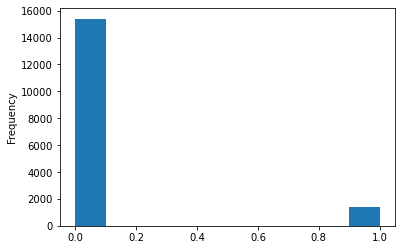

In [384]:
app_train['TARGET'].astype(int).plot.hist();

In [385]:
app_test['TARGET'].value_counts()

0    6601
1     599
Name: TARGET, dtype: int64

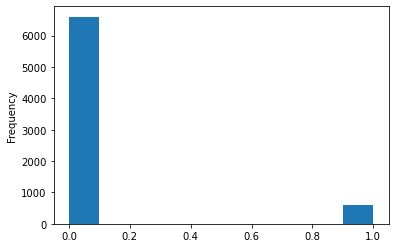

In [386]:
app_test['TARGET'].astype(int).plot.hist();

In [387]:
app_train.dtypes.value_counts()

int64      16
float64    10
object      9
dtype: int64

In [388]:
def bar_chart(feature):
    default = app_train[app_train['TARGET']==1][feature].value_counts()
    positive= app_train[app_train['TARGET']==0][feature].value_counts()
    df = pd.DataFrame([default,positive])
    df.index = ['Default', 'Positive']
    df.plot(kind = 'bar', stacked=True, figsize=(10,5))

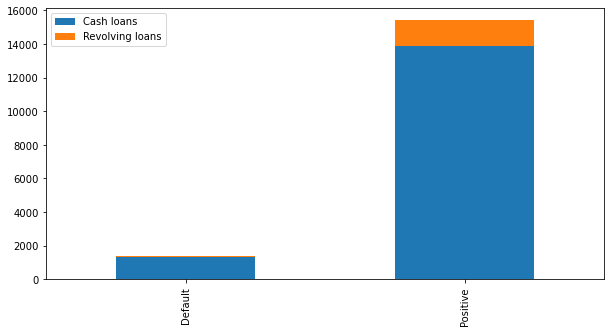

In [389]:
# 1. NAME_CONTRACT_TYPE
bar_chart('NAME_CONTRACT_TYPE')

일반대출 연체가 높다.

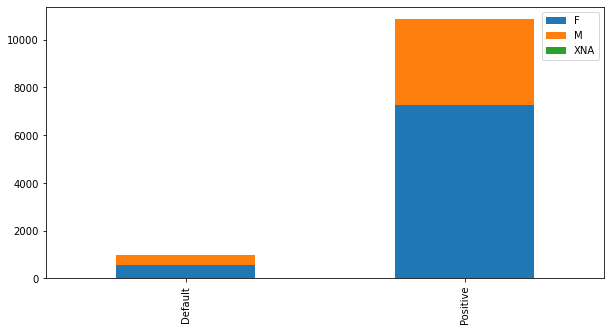

In [390]:
# 2. CODE_GENDER
bar_chart('CODE_GENDER')

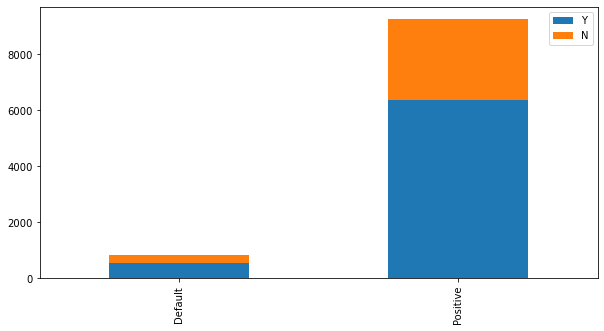

In [391]:
# 3. FLAG_OWN_REALTY
bar_chart('FLAG_OWN_REALTY')

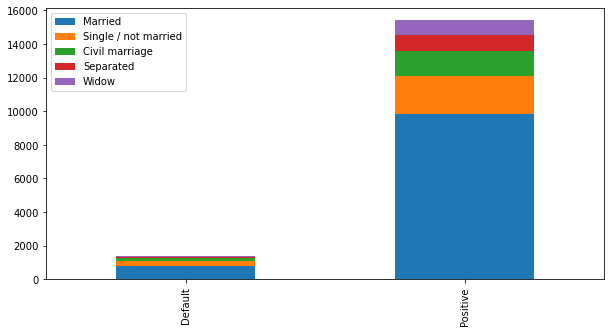

In [392]:
# 4. NAME_FAMILY_STATUS
bar_chart('NAME_FAMILY_STATUS')

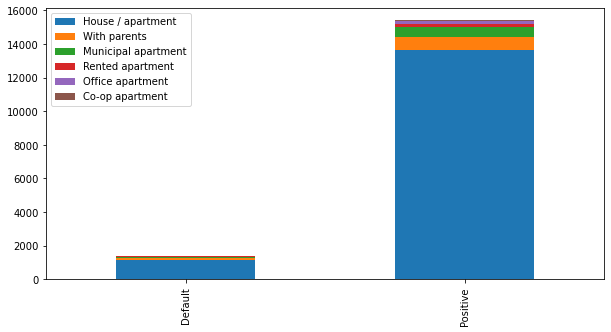

In [393]:
# 5. NAME_HOUSING_TYPE
bar_chart('NAME_HOUSING_TYPE')

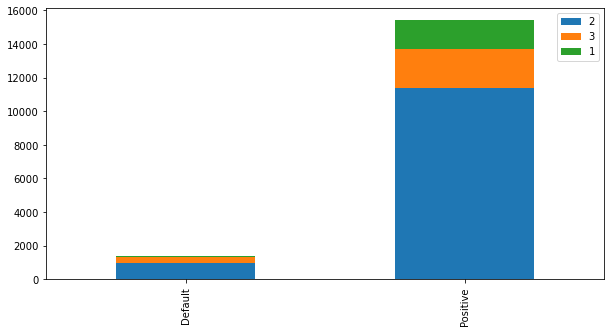

In [394]:
# 6. REGION_RATING_CLIENT
bar_chart('REGION_RATING_CLIENT')

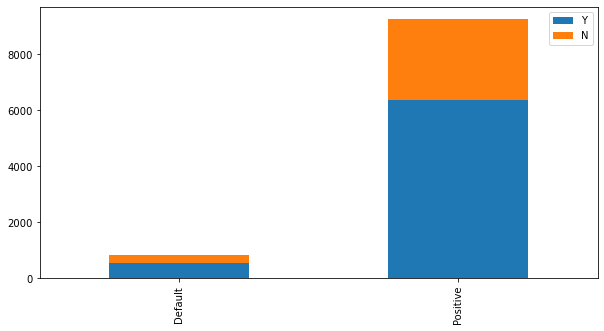

In [395]:
# 7. FLAG_OWN_REALTY
bar_chart('FLAG_OWN_REALTY')

### 1-1. 오브젝트 타입 분석

In [396]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_REALTY                2
NAME_INCOME_TYPE               6
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

- 범주형 변수 뒤에서 숫자형으로 바꾸자 (라벨 인코딩)
- 원핫인코딩도 고려

In [397]:
app_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         15207
Revolving loans     1593
Name: NAME_CONTRACT_TYPE, dtype: int64

In [398]:
def labelencoder_counter(df) :
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if app_train[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(app_train[col])
                # Transform both training and testing data
                app_train[col] = le.transform(app_train[col])
                app_test[col] = le.transform(app_test[col])

                # Keep track of how many columns were label encoded
                le_count += 1

    return print('%d columns were label encoded.' % le_count)

In [399]:
labelencoder_counter(app_train)

1 columns were label encoded.


In [400]:
app_train['NAME_CONTRACT_TYPE'].value_counts()

0    15207
1     1593
Name: NAME_CONTRACT_TYPE, dtype: int64

## 1-2. One-hot encoding
- 고유값 칼럼 1, 나머지 0
- train / test 데이터 모두 동일한 열 필요
- 열을 기준으로 정렬하자 : axis = 1

In [401]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (16800, 119)
Testing Features shape:  (7200, 117)


- 학습(train) / 시험(test) 데이터에 모두 동일한 열이 필요함.
- 열을 기준으로 정렬 : axis = 1

In [402]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (16800, 115)
Testing Features shape:  (7200, 115)


## 1-3. 상관관계 분석
- 함수 : correlations(number)
- number 에 파악하고자 하는 숫자를 입력.

In [403]:
def correlations(number) :
    # Find correlations with the target and sort
    correlations = app_train.corr()['TARGET'].sort_values()

    # Display correlations
    print('Most Positive Correlations:\n', correlations.tail(20))
    print('\nMost Negative Correlations:\n', correlations.head(20))

In [404]:
correlations(10)

Most Positive Correlations:
 ORGANIZATION_TYPE_Industry: type 3                   0.028721
FLAG_WORK_PHONE                                      0.029592
NAME_HOUSING_TYPE_Rented apartment                   0.031313
NAME_FAMILY_STATUS_Civil marriage                    0.035384
LIVE_CITY_NOT_WORK_CITY                              0.035984
REG_CITY_NOT_LIVE_CITY                               0.038709
DAYS_ID_PUBLISH                                      0.040398
NAME_FAMILY_STATUS_Single / not married              0.040806
CODE_GENDER_M                                        0.041075
NAME_HOUSING_TYPE_With parents                       0.042520
FLAG_EMP_PHONE                                       0.043978
FLAG_DOCUMENT_3                                      0.047313
REG_CITY_NOT_WORK_CITY                               0.053278
NAME_EDUCATION_TYPE_Secondary / secondary special    0.057133
REGION_RATING_CLIENT                                 0.061863
NAME_INCOME_TYPE_Working                 

상관계수
- 일반적인 해석
- .00-.19 : very weak
- .20-.39 : weak
- .40-.59 : moderate
- .60-.79 : strong
- .80-1.0 :very strong
- TARGET 과 DAYS_BIRTH 의 상관관계가 가장 높은 것으로 확인됨.

- FLAG_MOBIL 좀 이상한데?

In [405]:
print("TRAIN :", app_train['FLAG_MOBIL'].value_counts())
print("TEST :", app_test['FLAG_MOBIL'].value_counts())

TRAIN : 1    16800
Name: FLAG_MOBIL, dtype: int64
TEST : 1    7200
Name: FLAG_MOBIL, dtype: int64


- FLAG_MOBIL 은 다 1이다. 날리자

In [406]:
app_train = app_train.drop('FLAG_MOBIL', axis=1)
app_test = app_test.drop('FLAG_MOBIL', axis=1)

In [408]:
app_train.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,...,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,383487,0,0,157500.0,NaN,0.019101,NaN,NaN,-14310.0,-4416.0,0,0,1,0,2,13,0,0,0,0,1,0,33.374599,79.470022,65.630811,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,141309,0,0,382500.0,675000.0,NaN,-12372.0,-3781.0,-4554.0,-1216.0,1,0,0,0,2,17,0,0,0,0,0,0,30.014200,47.605049,NaN,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,372171,0,0,81000.0,101880.0,0.035792,-19051.0,-12088.0,-7115.0,-2586.0,1,0,0,0,2,14,0,0,0,0,1,0,54.844571,77.855600,57.771857,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,117989,1,0,180000.0,675000.0,0.006207,-20268.0,-4394.0,-9662.0,NaN,1,0,0,0,2,11,0,0,0,0,0,0,NaN,75.531946,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,112869,0,0,153000.0,276277.5,0.010006,-21914.0,365243.0,-1046.0,-3765.0,0,0,0,0,2,12,1,0,0,0,1,0,NaN,65.240198,NaN,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## 1-4. 결측치(Missing Value) 확인
- 함수 : missing_values_table(df)
- df 에 읽은 파일을 변수로 입력 

In [409]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [410]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values

Your selected dataframe has 114 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
DAYS_REGISTRATION,6829,40.6
CB_SCORE_2,5791,34.5
AMT_CREDIT,5148,30.6
DAYS_EMPLOYED,5030,29.9
REGION_POPULATION_RELATIVE,5010,29.8
CB_SCORE_3,4907,29.2
CB_SCORE_1,4297,25.6
DAYS_ID_PUBLISH,3359,20.0
DAYS_BIRTH,3350,19.9


- 결측값 채워 넣어야함
- 다음 결측치 비율 높은 이 열을 어떻게 활용할지 고민할 예정

이상치 확인
- 상관관계가 가장 Column을 먼저 분석함.
- DAYS_BIRTH : 현재 대출과 비교하여 기록되기 때문에 음수이므로 나누기를 음수로 하여 더 쉽게 나이를 확인할 수 있도록 함.
- mean : 평균
- min : 최솟값
- max : 최댓값
- std : 표준편차

# 2.1 Nan값 생성 & 변수생성

## 나이

In [411]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    13450.000000
mean        43.855264
std         11.941442
min         21.063014
25%         33.873973
50%         43.058904
75%         53.736986
max         68.972603
Name: DAYS_BIRTH, dtype: float64

In [412]:
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365

In [413]:
app_test['YEARS_BIRTH'] = app_test['DAYS_BIRTH'] / -365

In [414]:
app_train['YEARS_BIRTH'].fillna(app_train.groupby("NAME_CONTRACT_TYPE")["YEARS_BIRTH"].transform("median"), inplace=True)

In [415]:
app_test['YEARS_BIRTH'].fillna(app_test.groupby("NAME_CONTRACT_TYPE")["YEARS_BIRTH"].transform("median"), inplace=True)

In [416]:
app_train['YEARS_BIRTH'].value_counts()

43.378082    3033
39.930137     321
36.786301       7
48.238356       6
59.939726       6
             ... 
38.391781       1
63.312329       1
32.049315       1
24.646575       1
40.967123       1
Name: YEARS_BIRTH, Length: 9134, dtype: int64

In [417]:
def _age(YEARS_BIRTH):
    r = 0
    if   YEARS_BIRTH < 20 : r = 0
    elif YEARS_BIRTH < 30 : r = 1
    elif YEARS_BIRTH < 40 : r = 2
    elif YEARS_BIRTH < 50 : r = 3
    elif YEARS_BIRTH < 60 : r = 4
    elif YEARS_BIRTH >=70 : r = 5
    return r

In [418]:
app_train['YEARS_BIRTH'] = app_train.apply(lambda x: _age(x['YEARS_BIRTH']), axis = 1)
app_test['YEARS_BIRTH'] = app_test.apply(lambda x: _age(x['YEARS_BIRTH']), axis = 1)

In [419]:
app_test['YEARS_BIRTH'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

In [420]:
app_train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,...,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH
0,383487,0,0,157500.0,NaN,0.019101,NaN,NaN,-14310.0,-4416.0,0,0,1,0,2,13,0,0,0,0,1,0,33.374599,79.470022,65.630811,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
1,141309,0,0,382500.0,675000.0,NaN,-12372.0,-3781.0,-4554.0,-1216.0,1,0,0,0,2,17,0,0,0,0,0,0,30.014200,47.605049,NaN,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,372171,0,0,81000.0,101880.0,0.035792,-19051.0,-12088.0,-7115.0,-2586.0,1,0,0,0,2,14,0,0,0,0,1,0,54.844571,77.855600,57.771857,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,117989,1,0,180000.0,675000.0,0.006207,-20268.0,-4394.0,-9662.0,NaN,1,0,0,0,2,11,0,0,0,0,0,0,NaN,75.531946,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4
4,112869,0,0,153000.0,276277.5,0.010006,-21914.0,365243.0,-1046.0,-3765.0,0,0,0,0,2,12,1,0,0,0,1,0,NaN,65.240198,NaN,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [421]:
def bar_chart2(feature):
    default = app_train[app_train['TARGET']==1][feature].value_counts()
    positive= app_train[app_train['TARGET']==0][feature].value_counts()
    df = pd.DataFrame([default,positive])
    df.index = ['Default', 'Positive']
    df.plot(kind = 'bar', stacked=True, figsize=(10,5))

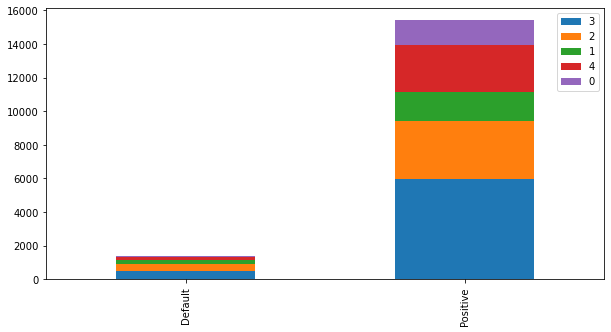

In [422]:
bar_chart2('YEARS_BIRTH')

In [423]:
app_train = app_train.drop('DAYS_BIRTH', axis=1)
app_test = app_test.drop('DAYS_BIRTH', axis=1)

## 재직년수

In [424]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    11770.000000
mean      -171.891858
std        384.598388
min      -1000.665753
25%          0.838356
50%          3.309589
75%          7.569863
max         46.169863
Name: DAYS_EMPLOYED, dtype: float64

In [425]:
app_train['YEARS_EMPLOYED'] = app_train['DAYS_EMPLOYED'] / -365

In [426]:
app_test['YEARS_EMPLOYED'] = app_test['DAYS_EMPLOYED'] / -365

In [427]:
app_train['YEARS_EMPLOYED'].fillna(app_train.groupby("NAME_CONTRACT_TYPE")["YEARS_EMPLOYED"].transform("median"), inplace=True)

In [428]:
app_test['YEARS_EMPLOYED'].fillna(app_test.groupby("NAME_CONTRACT_TYPE")["YEARS_EMPLOYED"].transform("median"), inplace=True)

In [429]:
app_train['YEARS_EMPLOYED'].value_counts()

 3.341096       4565
-1000.665753    2085
 3.139726        465
 0.608219         13
 0.495890         11
                ... 
 13.764384         1
 5.169863          1
 10.482192         1
 11.101370         1
 23.457534         1
Name: YEARS_EMPLOYED, Length: 4600, dtype: int64

In [430]:
app_train['YEARS_EMPLOYED'].describe()

count    16800.000000
mean      -119.431851
std        331.762913
min      -1000.665753
25%          1.823973
50%          3.341096
75%          5.380822
max         46.169863
Name: YEARS_EMPLOYED, dtype: float64

In [431]:
app_test['YEARS_EMPLOYED'].describe()

count    7200.000000
mean     -122.263199
std       335.011582
min     -1000.665753
25%         1.819178
50%         3.287671
75%         5.319178
max        44.800000
Name: YEARS_EMPLOYED, dtype: float64

In [432]:
def _job_y(YEARS_EMPLOYED):
    r = 0
    if   YEARS_EMPLOYED <= 0  : r = 0
    elif YEARS_EMPLOYED <= 3  : r = 1
    elif YEARS_EMPLOYED <= 5  : r = 2
    elif YEARS_EMPLOYED <  7  : r = 3
    elif YEARS_EMPLOYED < 20  : r = 4
    elif YEARS_EMPLOYED > 30  : r = 5
    return r

In [433]:
app_train['YEARS_EMPLOYED'] = app_train.apply(lambda x: _job_y(x['YEARS_EMPLOYED']), axis = 1)
app_test['YEARS_EMPLOYED'] = app_test.apply(lambda x: _job_y(x['YEARS_EMPLOYED']), axis = 1)

In [434]:
print("Train :", app_train['YEARS_EMPLOYED'].unique())
print("Test :", app_test['YEARS_EMPLOYED'].unique())

Train : [2 4 5 0 1 3]
Test : [1 2 0 4 5 3]


In [435]:
app_train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED
0,383487,0,0,157500.0,NaN,0.019101,NaN,-14310.0,-4416.0,0,0,1,0,2,13,0,0,0,0,1,0,33.374599,79.470022,65.630811,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2
1,141309,0,0,382500.0,675000.0,NaN,-3781.0,-4554.0,-1216.0,1,0,0,0,2,17,0,0,0,0,0,0,30.014200,47.605049,NaN,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
2,372171,0,0,81000.0,101880.0,0.035792,-12088.0,-7115.0,-2586.0,1,0,0,0,2,14,0,0,0,0,1,0,54.844571,77.855600,57.771857,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
3,117989,1,0,180000.0,675000.0,0.006207,-4394.0,-9662.0,NaN,1,0,0,0,2,11,0,0,0,0,0,0,NaN,75.531946,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,4
4,112869,0,0,153000.0,276277.5,0.010006,365243.0,-1046.0,-3765.0,0,0,0,0,2,12,1,0,0,0,1,0,NaN,65.240198,NaN,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

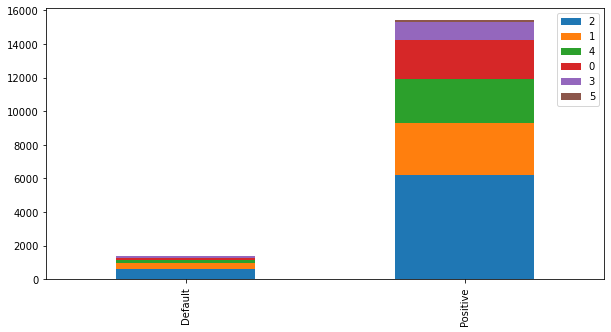

In [436]:
bar_chart2('YEARS_EMPLOYED')

In [437]:
app_train = app_train.drop('DAYS_EMPLOYED', axis=1)
app_test = app_test.drop('DAYS_EMPLOYED', axis=1)

## CB Score 1,2,3

In [438]:
app_train['CB_SCORE_1'].describe()

count    12503.000000
mean        49.951071
std         13.057762
min          0.000000
25%         41.078155
50%         50.009869
75%         58.977346
max         99.870790
Name: CB_SCORE_1, dtype: float64

In [439]:
app_train['CB_SCORE_1'].isnull().sum()

4297

In [440]:
app_train['CB_SCORE_2'].describe()

count    11009.000000
mean        58.088505
std         10.770080
min          0.000000
25%         50.833734
50%         57.900671
75%         65.231325
max         98.987986
Name: CB_SCORE_2, dtype: float64

In [441]:
app_train['CB_SCORE_2'].isnull().sum()

5791

In [442]:
app_train['CB_SCORE_3'].describe()

count    11893.000000
mean        60.390198
std          8.705020
min         28.967147
25%         54.346475
50%         60.018619
75%         66.135866
max        100.000000
Name: CB_SCORE_3, dtype: float64

In [443]:
app_train['CB_SCORE_3'].isnull().sum()

4907

In [444]:
app_train['CB_SCORE_1'].fillna(app_train.groupby("YEARS_BIRTH")["CB_SCORE_1"].transform("median"), inplace=True)
app_test['CB_SCORE_1'].fillna(app_test.groupby("YEARS_BIRTH")["CB_SCORE_1"].transform("median"), inplace=True)

In [445]:
app_train['CB_SCORE_1'].describe()

count    16800.000000
mean        49.939076
std         11.300556
min          0.000000
25%         44.385661
50%         49.785762
75%         55.504050
max         99.870790
Name: CB_SCORE_1, dtype: float64

In [446]:
app_train['CB_SCORE_1'].isnull().sum()

0

In [447]:
app_train['CB_SCORE_2'].fillna(app_train.groupby("YEARS_BIRTH")["CB_SCORE_2"].transform("median"), inplace=True)
app_test['CB_SCORE_2'].fillna(app_test.groupby("YEARS_BIRTH")["CB_SCORE_2"].transform("median"), inplace=True)

In [448]:
app_train['CB_SCORE_3'].fillna(app_train.groupby("YEARS_BIRTH")["CB_SCORE_3"].transform("median"), inplace=True)
app_test['CB_SCORE_3'].fillna(app_test.groupby("YEARS_BIRTH")["CB_SCORE_3"].transform("median"), inplace=True)

## CB 구간 설정

In [449]:
def _CB(KIND_SCORE):
    r = 0
    if   KIND_SCORE <= 0  : r = 0
    elif KIND_SCORE <= 20 : r = 1
    elif KIND_SCORE <= 35 : r = 2
    elif KIND_SCORE <= 50 : r = 3
    elif KIND_SCORE <= 65 : r = 4
    elif KIND_SCORE <= 80 : r = 5
    elif KIND_SCORE >  95 : r = 6
    return r

In [450]:
app_train['CB_SCORE_1'] = app_train.apply(lambda x: _CB(x['CB_SCORE_1']), axis = 1)
app_test['CB_SCORE_1']  = app_test.apply(lambda x: _CB(x['CB_SCORE_1']), axis = 1)

In [451]:
print("Train :", app_train['CB_SCORE_1'].unique())
print("Test :", app_test['CB_SCORE_1'].unique())

Train : [2 4 3 1 5 0 6]
Test : [4 3 5 2 0 1 6]


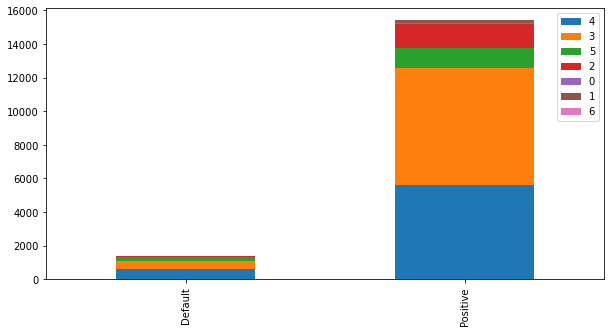

In [452]:
bar_chart2('CB_SCORE_1')

- CB_2

In [453]:
app_train['CB_SCORE_2'] = app_train.apply(lambda x: _CB(x['CB_SCORE_2']), axis = 1)
app_test['CB_SCORE_2']  = app_test.apply(lambda x: _CB(x['CB_SCORE_2']), axis = 1)

In [454]:
print("Train :", app_train['CB_SCORE_2'].unique())
print("Test :", app_test['CB_SCORE_2'].unique())

Train : [5 3 4 2 0 6 1]
Test : [4 3 5 0 2 6]


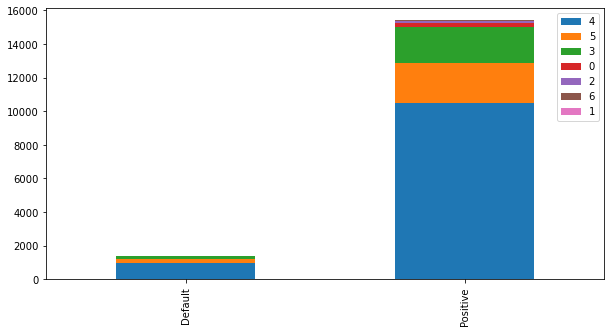

In [455]:
bar_chart2('CB_SCORE_2')

- CB_3

In [456]:
app_train['CB_SCORE_3'] = app_train.apply(lambda x: _CB(x['CB_SCORE_3']), axis = 1)
app_test['CB_SCORE_3']  = app_test.apply(lambda x: _CB(x['CB_SCORE_3']), axis = 1)

In [457]:
print("Train :", app_train['CB_SCORE_3'].unique())
print("Test :", app_test['CB_SCORE_3'].unique())

Train : [5 4 3 0 6 2]
Test : [4 5 3 0 2 6]


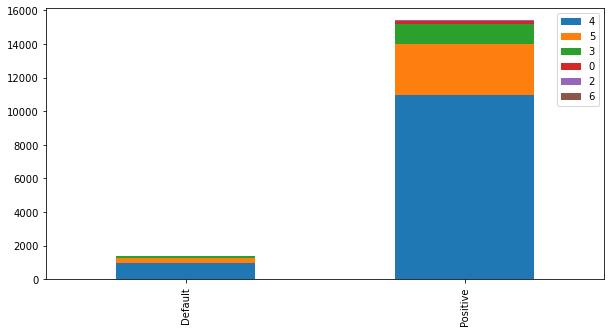

In [458]:
bar_chart2('CB_SCORE_3')

## 새로운 변수 탐색
## 소득 금액(USD)

In [459]:
app_train['AMT_INCOME_TOTAL'].value_counts()

135000.0    1943
112500.0    1682
157500.0    1414
180000.0    1300
90000.0     1279
            ... 
97915.5        1
113400.0       1
354375.0       1
340200.0       1
113850.0       1
Name: AMT_INCOME_TOTAL, Length: 399, dtype: int64

In [460]:
app_train['AMT_INCOME_TOTAL'].describe()

count    1.680000e+04
mean     1.740629e+05
std      9.067355e+05
min      2.700000e+04
25%      1.125000e+05
50%      1.440000e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

- 단위 조정 후 구간 설정하자
- $ 1,000

In [461]:
app_train['AMT_INCOME_TOTAL'] = app_train['AMT_INCOME_TOTAL'] / 1000
app_test['AMT_INCOME_TOTAL'] = app_test['AMT_INCOME_TOTAL'] / 1000

In [462]:
app_train['AMT_INCOME_TOTAL'].describe()

count     16800.000000
mean        174.062918
std         906.735478
min          27.000000
25%         112.500000
50%         144.000000
75%         202.500000
max      117000.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [463]:
app_test['AMT_INCOME_TOTAL'].describe()

count    7200.000000
mean      168.913738
std        96.375468
min        27.000000
25%       112.500000
50%       144.450000
75%       202.500000
max      2025.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [464]:
print("Train 결측치:", app_train['AMT_INCOME_TOTAL'].isnull().sum())
print("Test 결측치:", app_test['AMT_INCOME_TOTAL'].isnull().sum())

Train 결측치: 0
Test 결측치: 0


In [488]:
def _amt(AMT_INCOME_TOTAL):
    r = 0
    if   AMT_INCOME_TOTAL <=  25 : r = 0
    elif AMT_INCOME_TOTAL <=  70 : r = 1
    elif AMT_INCOME_TOTAL <= 120 : r = 2
    elif AMT_INCOME_TOTAL <= 180 : r = 3
    elif AMT_INCOME_TOTAL <= 230 : r = 4
    elif AMT_INCOME_TOTAL <= 280 : r = 5
    elif AMT_INCOME_TOTAL >  280 : r = 6
    return r

In [489]:
app_train['AMT_INCOME_TOTAL'] = app_train.apply(lambda x: _amt(x['AMT_INCOME_TOTAL']), axis = 1)
app_test['AMT_INCOME_TOTAL']  = app_test.apply(lambda x: _amt(x['AMT_INCOME_TOTAL']), axis = 1)

In [490]:
print("Train :", app_train['AMT_INCOME_TOTAL'].unique())
print("Test :", app_test['AMT_INCOME_TOTAL'].unique())

Train : [3 6 2 1 5 4]
Test : [2 6 4 1 3 5]


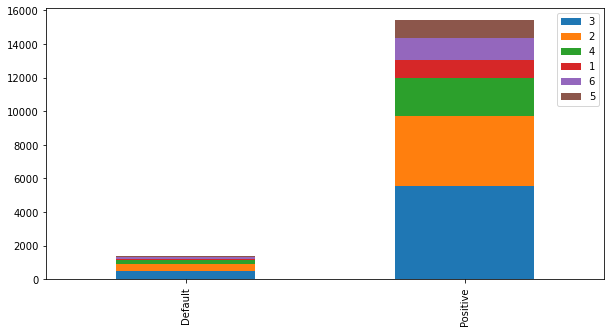

In [491]:
bar_chart2('AMT_INCOME_TOTAL')

커널 밀도 추정
- 연령이 대상에 미치는 영향을 시각화(seaborn kdeplot 사용).

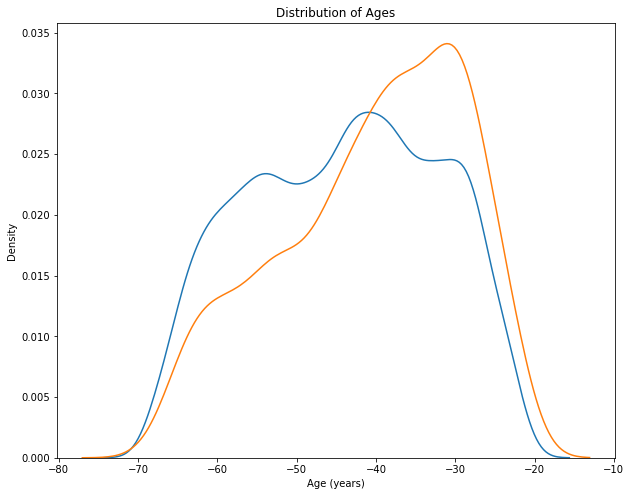

In [188]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

나이를 5년 단위로 분리하여 데이터 분석
- 나이 변수를 절대값으로 변환하여 확인이 쉽도록 변경함.

In [189]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [190]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,0,NaN,NaN,NaN
1,0,12372.0,33.895890,"(30.0, 35.0]"
2,0,19051.0,52.194521,"(50.0, 55.0]"
3,0,20268.0,55.528767,"(55.0, 60.0]"
4,0,21914.0,60.038356,"(60.0, 65.0]"
5,0,NaN,NaN,NaN
6,0,8654.0,23.709589,"(20.0, 25.0]"
7,0,NaN,NaN,NaN
8,0,9546.0,26.153425,"(25.0, 30.0]"
9,0,21105.0,57.821918,"(55.0, 60.0]"


In [191]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.130268,8546.601533,23.415347
"(25.0, 30.0]",0.115564,10144.313293,27.792639
"(30.0, 35.0]",0.113085,11842.905269,32.446316
"(35.0, 40.0]",0.103110,13709.458265,37.560160
"(40.0, 45.0]",0.081224,15491.653481,42.442886
"(45.0, 50.0]",0.067371,17317.317701,47.444706
"(50.0, 55.0]",0.064599,19185.801680,52.563840
"(55.0, 60.0]",0.055754,20971.281630,57.455566
"(60.0, 65.0]",0.063812,22762.255248,62.362343


- 오 이런 .. 나이가 어릴수록 default 비율이 더 높은 것을 알 수 있음.

In [106]:
cb_data = app_train[['TARGET', 'CB_SCORE_1', 'CB_SCORE_2', 'CB_SCORE_3', 'YEARS_BIRTH']]
cb_data_corrs = cb_data.corr()
cb_data_corrs

,TARGET,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,YEARS_BIRTH
TARGET,1.000000,0.094136,0.012865,-0.014253,-0.031523
CB_SCORE_1,0.094136,1.000000,-0.002379,-0.004719,-0.083671
CB_SCORE_2,0.012865,-0.002379,1.000000,-0.000277,0.000709
CB_SCORE_3,-0.014253,-0.004719,-0.000277,1.000000,-0.001074
YEARS_BIRTH,-0.031523,-0.083671,0.000709,-0.001074,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

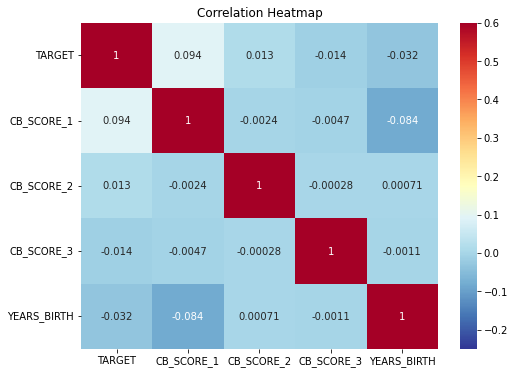

In [107]:
plt.figure(figsize=(8, 6))

sns.heatmap(cb_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, 
            annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

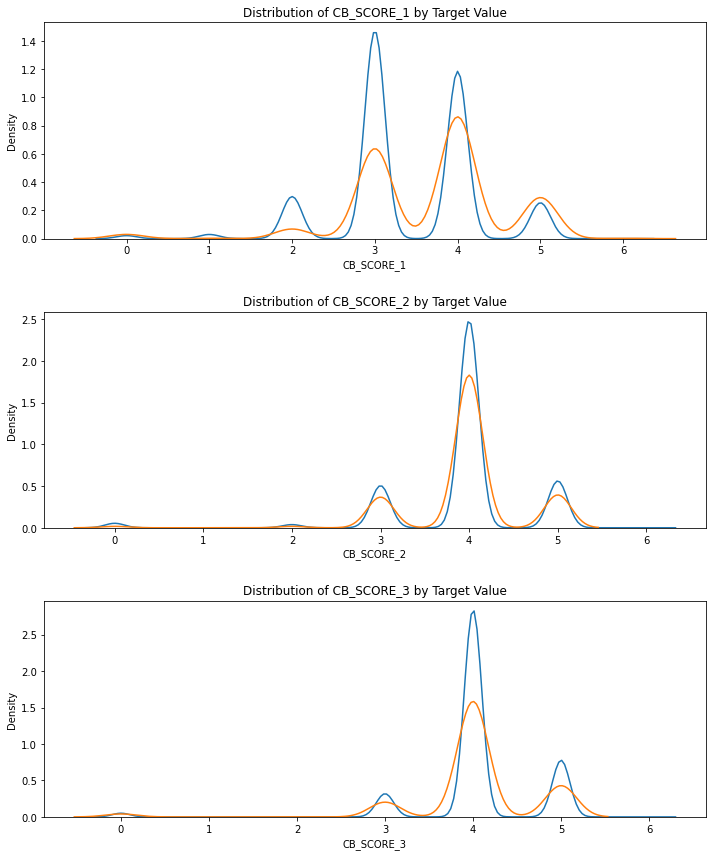

In [108]:
plt.figure(figsize=(10, 12))

for i, source in enumerate(["CB_SCORE_1", "CB_SCORE_2", "CB_SCORE_3"]):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train["TARGET"] == 0, source], label="target == 0")
    sns.kdeplot(app_train.loc[app_train["TARGET"] == 1, source], label="target == 1")
    
    plt.title("Distribution of %s by Target Value" % source)
    plt.xlabel("%s" % source)
    plt.ylabel("Density")
    
plt.tight_layout(h_pad=2.5)

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

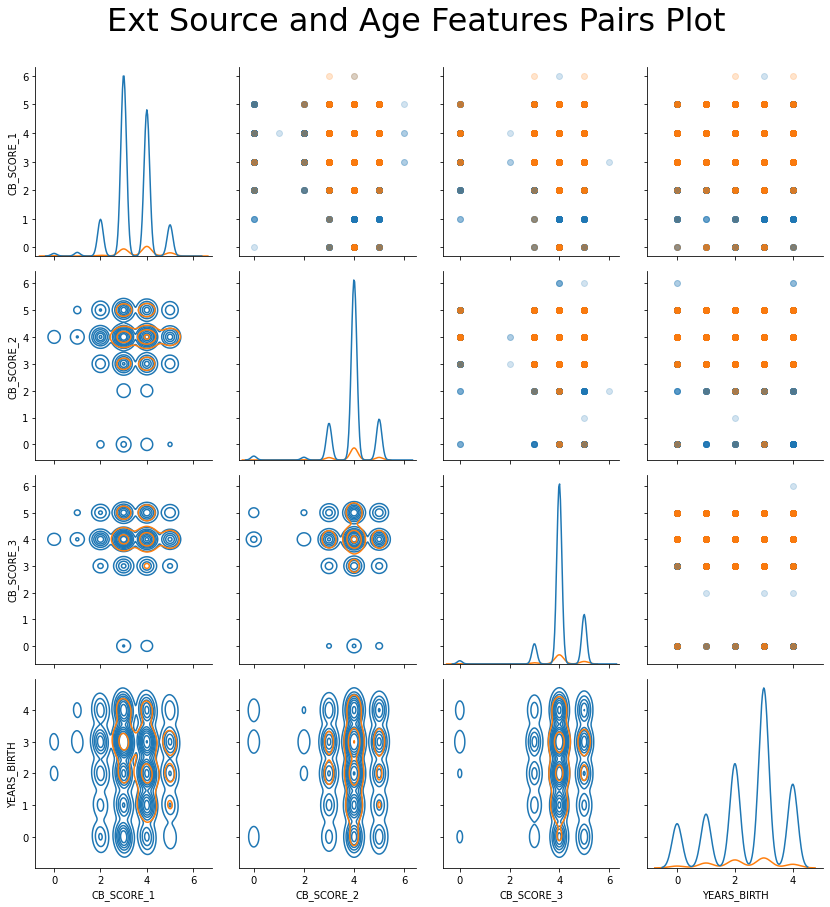

In [112]:
plot_data = cb_data.copy()
plot_data["YEARS_BIRTH"] = app_train["YEARS_BIRTH"]

plot_data = plot_data.dropna().loc[:100000, :]

grid = sns.PairGrid(data=plot_data, size=3, diag_sharey=False,
                    hue="TARGET",
                    vars=[x for x in list(plot_data.columns) if x!= "TARGET"])

# 대각선 위의 그래프로는 scatterplot
grid.map_upper(plt.scatter, alpha=0.2)

# 대각선은 kdeplot
grid.map_diag(sns.kdeplot)

# 대각선 아래는 density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)
plt.suptitle("CB Score and Age Features Pairs Plot", size=32, y=1.05)

In [126]:
app_train.isnull().sum()

SK_ID_CURR                                0
NAME_CONTRACT_TYPE                        0
CNT_CHILDREN                              0
AMT_INCOME_TOTAL                          0
AMT_CREDIT                             5148
                                       ... 
ORGANIZATION_TYPE_Transport: type 4       0
ORGANIZATION_TYPE_University              0
ORGANIZATION_TYPE_XNA                     0
YEARS_BIRTH                               0
YEARS_EMPLOYED                            0
Length: 116, dtype: int64

## 신용대출 금액

In [360]:
app_train['AMT_CREDIT'] = app_train['AMT_CREDIT'] / 1000
app_test['AMT_CREDIT'] = app_test['AMT_CREDIT'] / 1000

In [361]:
app_train['AMT_CREDIT'].describe()

count    11652.000000
mean       592.997890
std        396.084545
min         45.000000
25%        270.000000
50%        509.501250
75%        808.650000
max       4050.000000
Name: AMT_CREDIT, dtype: float64

In [362]:
app_test['AMT_CREDIT'].describe()

count    5048.000000
mean      601.028768
std       405.023321
min        45.000000
25%       270.000000
50%       513.801000
75%       810.000000
max      3150.000000
Name: AMT_CREDIT, dtype: float64

In [493]:
print("Train 결측치:", app_train['AMT_CREDIT'].isnull().sum())
print("Test 결측치:", app_test['AMT_CREDIT'].isnull().sum())

Train 결측치: 0
Test 결측치: 0


In [369]:
app_train['AMT_CREDIT'].fillna(0, inplace = True)
app_test['AMT_CREDIT'].fillna(0, inplace = True)

In [494]:
app_train['AMT_CREDIT'].describe()

count    16800.000000
mean       411.286394
std        428.423385
min          0.000000
25%          0.000000
50%        288.832500
75%        668.304000
max       4050.000000
Name: AMT_CREDIT, dtype: float64

In [495]:
app_test['AMT_CREDIT'].describe()

count    7200.000000
mean      421.387947
std       436.709486
min         0.000000
25%         0.000000
50%       292.500000
75%       675.000000
max      3150.000000
Name: AMT_CREDIT, dtype: float64

In [496]:
def _amt_c(AMT_CREDIT):
    r = 0
    if   AMT_CREDIT <=   0 : r = 0
    elif AMT_CREDIT <= 150 : r = 1
    elif AMT_CREDIT <= 300 : r = 2
    elif AMT_CREDIT <= 450 : r = 3
    elif AMT_CREDIT <= 600 : r = 4
    elif AMT_CREDIT <= 750 : r = 5
    elif AMT_CREDIT >  750 : r = 6
    return r

In [497]:
app_train['AMT_CREDIT'] = app_train.apply(lambda x: _amt_c(x['AMT_CREDIT']), axis = 1)
app_test['AMT_CREDIT']  = app_test.apply(lambda x: _amt_c(x['AMT_CREDIT']), axis = 1)

In [498]:
app_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED
0,383487,0,0,3,0,0.019101,-14310.0,-4416.0,0,0,1,0,2,13,0,0,0,0,1,0,2,5,5,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2
1,141309,0,0,6,5,NaN,-4554.0,-1216.0,1,0,0,0,2,17,0,0,0,0,0,0,2,3,4,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
2,372171,0,0,2,1,0.035792,-7115.0,-2586.0,1,0,0,0,2,14,0,0,0,0,1,0,4,5,4,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
3,117989,1,0,3,5,0.006207,-9662.0,NaN,1,0,0,0,2,11,0,0,0,0,0,0,3,5,4,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,4
4,112869,0,0,3,2,0.010006,-1046.0,-3765.0,0,0,0,0,2,12,1,0,0,0,1,0,3,5,4,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [499]:
print("Train :", app_train['AMT_INCOME_TOTAL'].unique())
print("Test :", app_test['AMT_INCOME_TOTAL'].unique())

Train : [3 6 2 1 5 4]
Test : [2 6 4 1 3 5]


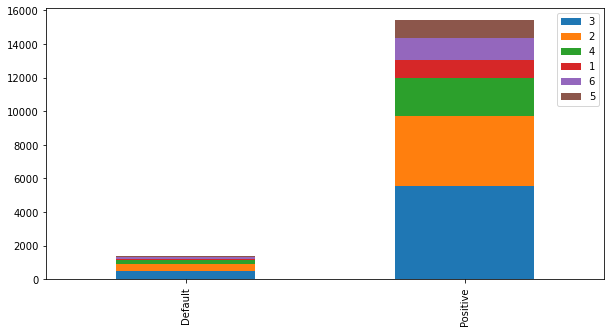

In [500]:
bar_chart2('AMT_INCOME_TOTAL')

- correlations 낮은 컬럼 삭제

In [514]:
app_train = app_train.drop('REGION_POPULATION_RELATIVE', axis=1)
app_test = app_test.drop('REGION_POPULATION_RELATIVE', axis=1)

app_train = app_train.drop('HOUR_APPR_PROCESS_START', axis=1)
app_test = app_test.drop('HOUR_APPR_PROCESS_START', axis=1)

app_train = app_train.drop('DAYS_ID_PUBLISH', axis=1)
app_test = app_test.drop('DAYS_ID_PUBLISH', axis=1)

app_train = app_train.drop('DAYS_REGISTRATION', axis=1)
app_test = app_test.drop('DAYS_REGISTRATION', axis=1)

In [515]:
correlations(10)

Most Positive Correlations:
 CNT_CHILDREN                                         0.016444
ORGANIZATION_TYPE_Business Entity Type 3             0.020667
ORGANIZATION_TYPE_Self-employed                      0.022785
ORGANIZATION_TYPE_Industry: type 3                   0.028721
FLAG_WORK_PHONE                                      0.029592
NAME_HOUSING_TYPE_Rented apartment                   0.031313
NAME_FAMILY_STATUS_Civil marriage                    0.035384
LIVE_CITY_NOT_WORK_CITY                              0.035984
REG_CITY_NOT_LIVE_CITY                               0.038709
NAME_FAMILY_STATUS_Single / not married              0.040806
CODE_GENDER_M                                        0.041075
NAME_HOUSING_TYPE_With parents                       0.042520
FLAG_EMP_PHONE                                       0.043978
FLAG_DOCUMENT_3                                      0.047313
REG_CITY_NOT_WORK_CITY                               0.053278
NAME_EDUCATION_TYPE_Secondary / secondary

In [516]:
app_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED
0,383487,0,0,3,0,0,0,1,0,2,0,0,0,0,1,0,2,5,5,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2
1,141309,0,0,6,5,1,0,0,0,2,0,0,0,0,0,0,2,3,4,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
2,372171,0,0,2,1,1,0,0,0,2,0,0,0,0,1,0,4,5,4,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
3,117989,1,0,3,5,1,0,0,0,2,0,0,0,0,0,0,3,5,4,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,4
4,112869,0,0,3,2,0,0,0,0,2,1,0,0,0,1,0,3,5,4,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# Model

In [518]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    labels = features['TARGET']
    
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
    
    elif encoding == 'le':
        
        label_encoder = LabelEncoder()
        
        cat_indices = []
        
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):
        
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        best_iteration = model.best_iteration_
        
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
    

In [519]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (16800, 108)
Testing Data Shape:  (7200, 108)
[200]	train's auc: 0.932194	train's binary_logloss: 0.434205	valid's auc: 0.647434	valid's binary_logloss: 0.515894
Baseline metrics
      fold     train     valid
0        0  0.904518  0.651449
1        1  0.816936  0.660385
2        2  0.856263  0.639755
3        3  0.818668  0.646789
4        4  0.821955  0.691059
5  overall  0.843668  0.656654


## 하나의 함수화

In [ ]:
""""전처리 내용 적용하기 위한 함수""""
def labelencoder_counter(x_test) :
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

return print('%d columns were label encoded.' % le_count)

In [ ]:
labelencoder_counter(x_test)

In [ ]:
# one-hot encoding of categorical variables
x_test   = pd.get_dummies(x_test)

print('Testing Features shape: ', x_test.shape)

In [ ]:
x_test = x_test.drop('FLAG_MOBIL', axis=1)
x_test = x_test.drop('REGION_POPULATION_RELATIVE', axis=1)
x_test = x_test.drop('HOUR_APPR_PROCESS_START', axis=1)
x_test = x_test.drop('DAYS_ID_PUBLISH', axis=1)
x_test = x_test.drop('DAYS_REGISTRATION', axis=1)

In [417]:
def _age(YEARS_BIRTH):
    r = 0
    if   YEARS_BIRTH < 20 : r = 0
    elif YEARS_BIRTH < 30 : r = 1
    elif YEARS_BIRTH < 40 : r = 2
    elif YEARS_BIRTH < 50 : r = 3
    elif YEARS_BIRTH < 60 : r = 4
    elif YEARS_BIRTH >=70 : r = 5
    return r

In [ ]:
x_test['YEARS_BIRTH'] = x_test['DAYS_BIRTH'] / -365

In [418]:
x_test['YEARS_BIRTH'] = x_test.apply(lambda x: _age(x['YEARS_BIRTH']), axis = 1)

In [432]:
def _job_y(YEARS_EMPLOYED):
    r = 0
    if   YEARS_EMPLOYED <= 0  : r = 0
    elif YEARS_EMPLOYED <= 3  : r = 1
    elif YEARS_EMPLOYED <= 5  : r = 2
    elif YEARS_EMPLOYED <  7  : r = 3
    elif YEARS_EMPLOYED < 20  : r = 4
    elif YEARS_EMPLOYED > 30  : r = 5
    return r

In [426]:
x_test['YEARS_EMPLOYED'] = x_test['DAYS_EMPLOYED'] / -365

In [433]:
x_test['YEARS_EMPLOYED'] = x_test.apply(lambda x: _job_y(x['YEARS_EMPLOYED']), axis = 1)

In [ ]:
def _CB(KIND_SCORE):
    r = 0
    if   KIND_SCORE <= 0  : r = 0
    elif KIND_SCORE <= 20 : r = 1
    elif KIND_SCORE <= 35 : r = 2
    elif KIND_SCORE <= 50 : r = 3
    elif KIND_SCORE <= 65 : r = 4
    elif KIND_SCORE <= 80 : r = 5
    elif KIND_SCORE >  95 : r = 6
    return r

In [ ]:
x_test['CB_SCORE_1']  = x_test.apply(lambda x: _CB(x['CB_SCORE_1']), axis = 1)
x_test['CB_SCORE_2']  = x_test.apply(lambda x: _CB(x['CB_SCORE_2']), axis = 1)
x_test['CB_SCORE_3']  = x_test.apply(lambda x: _CB(x['CB_SCORE_3']), axis = 1)

In [ ]:
def _amt(AMT_INCOME_TOTAL):
    r = 0
    if   AMT_INCOME_TOTAL <=  25 : r = 0
    elif AMT_INCOME_TOTAL <=  70 : r = 1
    elif AMT_INCOME_TOTAL <= 120 : r = 2
    elif AMT_INCOME_TOTAL <= 180 : r = 3
    elif AMT_INCOME_TOTAL <= 230 : r = 4
    elif AMT_INCOME_TOTAL <= 280 : r = 5
    elif AMT_INCOME_TOTAL >  280 : r = 6
    return r

In [ ]:
x_test['AMT_INCOME_TOTAL'] = x_test['AMT_INCOME_TOTAL'] / 1000

In [ ]:
x_test['AMT_INCOME_TOTAL']  = x_test.apply(lambda x: _amt(x['AMT_INCOME_TOTAL']), axis = 1)

In [ ]:
def _amt_c(AMT_CREDIT):
    r = 0
    if   AMT_CREDIT <=   0 : r = 0
    elif AMT_CREDIT <= 150 : r = 1
    elif AMT_CREDIT <= 300 : r = 2
    elif AMT_CREDIT <= 450 : r = 3
    elif AMT_CREDIT <= 600 : r = 4
    elif AMT_CREDIT <= 750 : r = 5
    elif AMT_CREDIT >  750 : r = 6
    return r

In [ ]:
x_test['AMT_CREDIT'] = x_test['AMT_CREDIT'] / 1000

In [ ]:
x_test['AMT_CREDIT']  = x_test.apply(lambda x: _amt_c(x['AMT_CREDIT']), axis = 1)

In [ ]:
x_test